# Importa bibliotecas

In [1]:
import pandas as pd
import glob
import numpy as np
from keras.models import Sequential, load_model
from keras.layers import SimpleRNN, Dense, Masking
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from keras.layers import Dropout
from sklearn.preprocessing import LabelEncoder
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint, CSVLogger, ReduceLROnPlateau
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import datetime
import pickle

2025-07-16 03:20:14.805109: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1752646814.855942   12515 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1752646814.873689   12515 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1752646814.944631   12515 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1752646814.944717   12515 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1752646814.944720   12515 computation_placer.cc:177] computation placer alr

## Definições

In [2]:
import os
import random
import tensorflow as tf

seed = 42
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['TF_DETERMINISTIC_OPS'] = '1'

random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

# Funções

In [3]:
def recover_model(checkpoint_filepath):
    initial_epoch = pd.read_csv('training_log.csv')['epoch'].iloc[-1] # pega a ultima epoch registrada no log
    model = load_model(checkpoint_filepath, compile=True) # 
    
    return model, initial_epoch

def save_history(history, timestamp):
    with open(f'training_history/pkl/{timestamp}.pkl', 'wb') as f:
        pickle.dump(history.history, f)


# Preparando dados

In [4]:
csv_files = glob.glob('/mnt/d/dados_surdos/CSVs/dados_pessoa2_*.csv')

dfs = []
for csv_file in csv_files:
    df = pd.read_csv(csv_file)
    dfs.append(df)

df = pd.concat(dfs, ignore_index=True)
df

landmark_0_x  landmark_0_y  landmark_0_z  landmark_1_x  landmark_1_y  \
0         -0.015607     -0.012011      0.085424      0.002198      0.002056   
1         -0.026881     -0.016575      0.088360     -0.004162      0.000434   
2         -0.035663     -0.030682      0.055793     -0.007602     -0.020255   
3         -0.019877     -0.012865      0.072611     -0.000591     -0.004493   
4         -0.017428      0.004787      0.097933      0.009870      0.017381   
...             ...           ...           ...           ...           ...   
32556     -0.006988      0.059106      0.065497      0.018958      0.042008   
32557     -0.009849      0.055787      0.067987      0.014397      0.041232   
32558     -0.010559      0.020268      0.080483      0.017107      0.022272   
32559     -0.009250     -0.018638      0.095681      0.017051     -0.004999   
32560      0.018331     -0.064629      0.065492      0.021411     -0.037175   

       landmark_1_z  landmark_2_x  landmark_2_y  landmark_2_z  landmark_3_x  \
0          0.062723      0.006184      0.013907      0.043209      0.012581   
1          0.064802     -0.002506      0.012053      0.047482      0.012059   
2          0.040326      0.010573     -0.015109      0.029176      0.034369   
3          0.054639      0.013915      0.000713      0.042367      0.027604   
4          0.064847      0.028842      0.017987      0.040486      0.040202   
...             ...           ...           ...           ...           ...   
32556      0.045603      0.036582      0.031468      0.027750      0.041668   
32557      0.047113      0.037282      0.032145      0.029211      0.048260   
32558      0.055852      0.036796      0.022708      0.033825      0.051180   
32559      0.066634      0.035379      0.004927      0.049955      0.049636   
32560      0.052570      0.011566     -0.012707      0.049884      0.002002   

       ...  landmark_18_z  landmark_19_x  landmark_19_y  landmark_19_z  \
0      ...       0.010308      -0.014324       0.022577       0.024143   
1      ...       0.006520      -0.015839       0.031193       0.016019   
2      ...       0.005534      -0.019610       0.026664       0.005605   
3      ...      -0.000779      -0.025155       0.012071      -0.001725   
4      ...       0.009571      -0.020957       0.031525       0.010485   
...    ...            ...            ...            ...            ...   
32556  ...       0.002797      -0.024219      -0.000852       0.008091   
32557  ...      -0.007995      -0.022478       0.014994      -0.003822   
32558  ...       0.001762      -0.009830       0.034790       0.009860   
32559  ...       0.011627      -0.027174       0.028498       0.016777   
32560  ...       0.009320      -0.018950       0.038877       0.014501   

       landmark_20_x  landmark_20_y  landmark_20_z  repetition  frame  \
0          -0.012121       0.028077       0.045234           0      0   
1          -0.011932       0.045492       0.040148           0      1   
2          -0.010181       0.035500       0.006776           0      2   
3          -0.019246       0.009204       0.004844           0      3   
4          -0.019979       0.045894       0.023430           0      4   
...              ...            ...            ...         ...    ...   
32556      -0.022274       0.007363       0.013810           9    147   
32557      -0.018179       0.023010       0.001642           9    148   
32558      -0.008334       0.042102       0.022468           9    149   
32559      -0.027771       0.039360       0.024744           9    150   
32560      -0.020016       0.059692       0.018554           9    151   

           word  
0        amanda  
1        amanda  
2        amanda  
3        amanda  
4        amanda  
...         ...  
32556  zimbabwe  
32557  zimbabwe  
32558  zimbabwe  
32559  zimbabwe  
32560  zimbabwe  

[32561 rows x 66 columns]

In [5]:
# Separa features e label
grouped = df.groupby(['word', 'repetition'])
X_raw = []
y_raw = []

In [6]:
# Normaliza features com valores entre 0 e 1
scaler = MinMaxScaler()
landmark_cols = list(df.columns[:63])
df[landmark_cols] = scaler.fit_transform(df[landmark_cols])

In [7]:
# prepara lista com frames agrupadas por video
for (word, rep), group in grouped:
    sequence = group[landmark_cols].values
    X_raw.append(sequence)
    y_raw.append(word)

X_raw é uma lista de sequências de frames, onde:

- cada item da lista representa um vídeo.

- cada vídeo é representado como um array 2D de shape (T, 63), onde:

    - T = número de frames (time steps) do vídeo (varia de vídeo para vídeo)

    - 63 = número de features por frame (21 pontos da mão × 3 coordenadas)

In [8]:
# Separa em treino, teste e validação de forma estratificada

X_temp, X_test, y_temp, y_test = train_test_split(
    X_raw, y_raw, test_size=0.3, stratify=y_raw)

X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.285, stratify=y_temp)

In [9]:
print(f"Treino - {(len(X_train)/len(X_raw))*100}%")
print(f"Teste - {(len(X_test)/len(X_raw))*100}%")
print(f"Validacao - {(len(X_val)/len(X_raw))*100}%")

Treino - 50.0%
Teste - 30.0%
Validacao - 20.0%


In [10]:
# Padding
max_len = max(len(seq) for seq in X_train) # define tamanho maximo das sequencias

X_train = pad_sequences(X_train, maxlen=max_len, padding='post', dtype='float32')
X_val = pad_sequences(X_val,   maxlen=max_len, padding='post', dtype='float32')
X_test = pad_sequences(X_test,  maxlen=max_len, padding='post', dtype='float32')

X_train.shape,X_val.shape,X_test.shape

((130, 247, 63), (52, 247, 63), (78, 247, 63))

In [11]:
# Encode das labels - OneHotEncoder
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(np.array(y_train))
y_val = label_encoder.transform(np.array(y_val))
y_test = label_encoder.transform(np.array(y_test))

y_train.shape,y_test.shape,y_val.shape

((130,), (78,), (52,))

# Criando o modelo

In [12]:
num_classes = 26 # palavras/labels

In [13]:
mask = Masking(mask_value=0.0, input_shape=(max_len, 63))
SRNN = SimpleRNN(64)
dense = Dense(num_classes, activation='softmax')

model = Sequential()
model.add(mask)
model.add(SRNN)
model.add(Dropout(0.3))
model.add(dense)

optimizer = Adam(learning_rate=0.001)

model.compile(
    optimizer=optimizer,
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
    # metrics=['mse'] # verificar por que ta dando erro
)
model.summary()

/home/victor/.local/lib/python3.10/site-packages/keras/src/layers/core/masking.py:48: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
2025-07-16 03:20:21.295753: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ masking (Masking)               │ (None, 247, 63)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn (SimpleRNN)          │ (None, 64)             │         8,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 26)             │         1,690 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,882 (38.60 KB)

 Trainable params: 9,882 (38.60 KB)

 Non-trainable params: 0 (0.00 B)

# Treinamento

In [14]:
# callbacks
timestamp = datetime.datetime.now().strftime('%Y%m%d_%H%M%S')
checkpoint_filepath = f'models/checkpoint.model.keras'

early_stop = EarlyStopping(patience=100, restore_best_weights=True)
csv_logger = CSVLogger('training_log.csv', append=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=100, min_lr=0.00001, verbose=1)
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True
)

In [15]:
epochs = 20000
initial_epoch = 0

# utilizar para recuperar um checkpoint perdido
# model, initial_epoch = recover_model(checkpoint_filepath) # descomentar linha para recuperar modelo

In [16]:
history = model.fit(
    X_train, y_train,
    batch_size=16,
    epochs=epochs,
    verbose=1,
    validation_data=(X_val, y_val),
    shuffle=True,
    callbacks=[model_checkpoint_callback,
               csv_logger,
               reduce_lr],
    initial_epoch=initial_epoch
)

Epoch 1/20000


2025-07-16 03:20:21.507709: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 92ms/step - accuracy: 0.0405 - loss: 3.5839 - val_accuracy: 0.0385 - val_loss: 3.3175 - learning_rate: 0.0010
Epoch 2/20000
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - accuracy: 0.0379 - loss: 3.3716 - val_accuracy: 0.0577 - val_loss: 3.2640 - learning_rate: 0.0010
Epoch 3/20000
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - accuracy: 0.0924 - loss: 3.2718 - val_accuracy: 0.1731 - val_loss: 3.2323 - learning_rate: 0.0010
Epoch 4/20000
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - accuracy: 0.0812 - loss: 3.2675 - val_accuracy: 0.1731 - val_loss: 3.1861 - learning_rate: 0.0010
Epoch 5/20000
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - accuracy: 0.0801 - loss: 3.2376 - val_accuracy: 0.1731 - val_loss: 3.0965 - learning_rate: 0.0010
Epoch 6/20000
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - accuracy: 0.1289 - loss: 3.0654 - val_accuracy: 0.1731 - val_loss: 3.0653 - learning_rate: 0.0010
Epoch 7/20000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.1492 - loss: 3.0828 - val_accuracy: 

# Avaliação do modelo

In [17]:
best_model = load_model(checkpoint_filepath) # o checkpoint salva apenas o melhor modelo
test_loss, test_accuracy = best_model.evaluate(X_test, y_test, verbose=0)
print(f"best model - accuracy: {test_accuracy:.4f}")
print(f"best model - loss: {test_loss:.4f}")

2025-07-16 06:59:51.094628: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


best model - accuracy: 0.6923
best model - loss: 1.0559


# Historico de treinamento

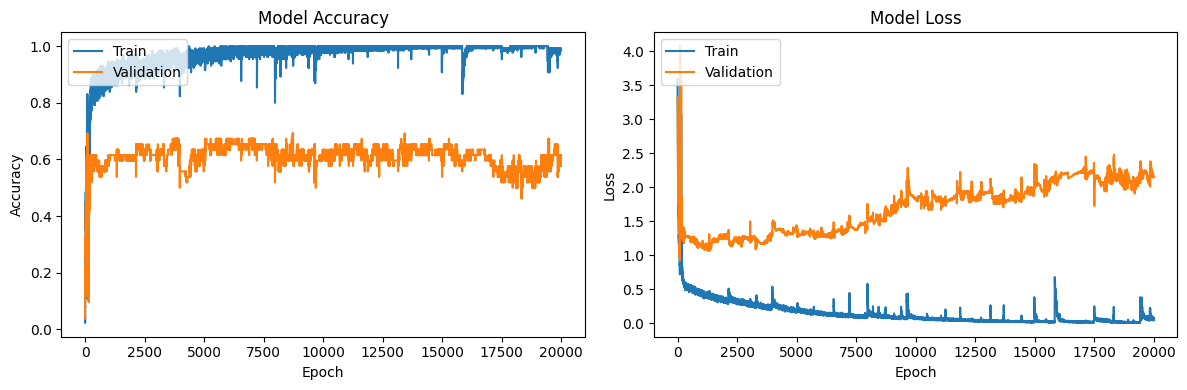

In [36]:
# historico de treinamento
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()

fig_file_path = f"training_history/img/{timestamp}.png"
# plt.savefig(fig_file_path) # se quiser salvar a imagem, descomentar a linha
plt.show()

In [ ]:
np.max(history.history['accuracy'])

0.692307710647583

In [56]:
np.min(history.history['loss'])

0.00690037664026022

In [ ]:
# salva historico de treinamento e melhor modelo

# save_history(history, timestamp) # descomentar linha para salvar pkl do historico
# best_model.save(f'models/{int(test_accuracy*100)}_{timestamp}.model.keras') # descomentar linha para salvar melhor modelo

# Previsao do modelo

In [20]:
y_pred = model.predict(X_test)

y_pred = np.argmax(y_pred, axis=1)
y_true = y_test

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step


In [21]:
labels = df['word'].unique()

cr = classification_report(y_true, y_pred, target_names=labels)
print(cr)

              precision    recall  f1-score   support

      amanda       1.00      0.67      0.80         3
     beatriz       1.00      0.67      0.80         3
      camila       0.00      0.00      0.00         3
      dublin       1.00      1.00      1.00         3
     eduardo       1.00      0.33      0.50         3
    fernando       0.25      0.33      0.29         3
    gabriela       0.00      0.00      0.00         3
   helsinque       0.67      0.67      0.67         3
      itália       0.00      0.00      0.00         3
     jacarta       0.40      0.67      0.50         3
       kyoto       0.33      0.33      0.33         3
  luxemburgo       0.50      0.33      0.40         3
     mariana       0.33      0.33      0.33         3
     nairobi       0.67      0.67      0.67         3
        oslo       0.50      0.33      0.40         3
    portugal       1.00      1.00      1.00         3
       qatar       0.00      0.00      0.00         3
     raphael       1.00    

/home/victor/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/victor/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/victor/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [22]:
# decodifica os nomes das classes
y_pred_labels = label_encoder.inverse_transform(y_pred)
y_true_labels = label_encoder.inverse_transform(y_true)

# visualiza os pares
for i in range(y_pred_labels.shape[0]):
    print(f"{i+1}. Verdadeiro: {y_true_labels[i]} | Previsto: {y_pred_labels[i]}")


1. Verdadeiro: helsinque | Previsto: helsinque
2. Verdadeiro: tokyo | Previsto: tokyo
3. Verdadeiro: fernando | Previsto: vancouver
4. Verdadeiro: william | Previsto: william
5. Verdadeiro: mariana | Previsto: mariana
6. Verdadeiro: zimbabwe | Previsto: zimbabwe
7. Verdadeiro: itália | Previsto: mariana
8. Verdadeiro: portugal | Previsto: portugal
9. Verdadeiro: dublin | Previsto: dublin
10. Verdadeiro: amanda | Previsto: amanda
11. Verdadeiro: uruguai | Previsto: uruguai
12. Verdadeiro: kyoto | Previsto: kyoto
13. Verdadeiro: yuri | Previsto: yuri
14. Verdadeiro: kyoto | Previsto: fernando
15. Verdadeiro: dublin | Previsto: dublin
16. Verdadeiro: luxemburgo | Previsto: tokyo
17. Verdadeiro: portugal | Previsto: portugal
18. Verdadeiro: oslo | Previsto: samuel
19. Verdadeiro: beatriz | Previsto: beatriz
20. Verdadeiro: camila | Previsto: itália
21. Verdadeiro: gabriela | Previsto: camila
22. Verdadeiro: raphael | Previsto: samuel
23. Verdadeiro: luxemburgo | Previsto: tokyo
24. Verdade